# Variational Equations

Variational equations are an essential tool in orbital mechanics. They can be used to measure the sensitivity of the system with respect to the initial conditions. For any differential equation of the form
$$\dot{r}(t) = F(r(t),t)$$
one can define a corresponding variational equation
$$\dot{\delta r}(t) = \frac{\partial F(r(t),t)}{\partial r} \delta r(t)$$
where $\delta r(t)$ is the variation of the trajectory $r(t)$. In the case of an N-body integration, the vector $r(t)$ contains the positions and velocities of all particles and has thus dimensions of $6N$. 

REBOUND supports variational equations when using the leapfrog, IAS15 and WHFast integrator. In the case of WHFast, the variational equations are integrator using a symplectic tangent map (Mikkola & Innanen 1999, Rein & Tamayo 2015).

This tutotial shows you how to use variational equations. Let us first setup a standard N-body simulation involving two planets.

In [1]:
import rebound
import numpy as np
def create_sim():
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(m=1e-3, a=1.0)
    sim.add(m=1e-3, a=1.76)
    sim.move_to_com()
    return sim
sim = create_sim()

Next, we add a set of variational particles to REBOUND. This is done with the following command

In [2]:
var_i = sim.add_var_1st_order()
print(var_i)

3


The `add_var_1st_order()` function returns an integer which corresponds to the index in the particle array of the first variational particle. Let us now print all particle which are currently in the simulation:

In [3]:
for p in sim.particles:
    print(p)

<rebound.Particle object, id=0 m=1.0 x=-0.00275548802495 y=0.0 z=0.0 vx=0.0 vy=-0.00175252608656 vz=0.0>
<rebound.Particle object, id=0 m=0.001 x=0.997244511975 y=0.0 z=0.0 vx=0.0 vy=0.998747348976 vz=0.0>
<rebound.Particle object, id=0 m=0.001 x=1.75824351297 y=0.0 z=0.0 vx=0.0 vy=0.753778737581 vz=0.0>
<rebound.Particle object, id=0 m=0.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, id=0 m=0.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, id=0 m=0.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>


The first three partciles are the original particles, the last three are the variational particles. Note that all variational particles have been initialized to 0 (for both their mass and their position). We need to set at least one of the coordinates to a finite value to see any effect (the variational equations are linear and an initial condition of $\delta r=0$ will stay $0$ for all $t$). In our case, let's move one planet in the x direction. Note that the magnitude of this initial value does not matter (once again, because the variational equations are linear). 

In [4]:
sim.particles[var_i+1].x = 1.

We can now integrate the system forward in time. Here, we integrate it for one orbit of the inner planet, i.e. until $t=2\pi$ and then print out the particle positions.

In [5]:
sim.integrate(2.*np.pi)
for p in sim.particles:
    print(p)

<rebound.Particle object, id=0 m=1.0 x=0.000585973522112 y=-0.000780754809358 z=0.0 vx=0.000342243018774 vy=-0.00032053337084 vz=0.0>
<rebound.Particle object, id=0 m=0.001 x=1.00108029183 y=0.0175136094125 z=0.0 vx=-0.0154050595847 vy=0.998808090189 vz=0.0>
<rebound.Particle object, id=0 m=0.001 x=-1.58705381395 y=0.763241199945 z=0.0 vx=-0.326837959189 vy=-0.678274719349 vz=0.0>
<rebound.Particle object, id=0 m=0.0 x=0.00111957728053 y=0.013509468301 z=0.0 vx=-0.0138290938192 vy=-0.00111977304899 vz=0.0>
<rebound.Particle object, id=0 m=0.0 x=-0.0976574737153 y=-13.5368919806 z=0.0 vx=13.8357335054 vy=1.10090913777 vz=0.0>
<rebound.Particle object, id=0 m=0.0 x=-0.0219198068115 y=0.0267563550174 z=0.0 vx=-0.00663968627659 vy=0.0187405464083 vz=0.0>


Note that even though only one variational particle was initially perturbed, after a finite time $t$, this perturbation is visible in all variational particles.

To get a better idea of what these variational equations describe, let us integrate the same system again, but this time for a longer time and let us also plot the position of the inner planet and it's corresponding variational particle while we integrate.

In [6]:
sim = create_sim()
var_i = sim.add_var_1st_order()
sim.particles[var_i+1].x = 1.
Noutput = 1000
times = np.linspace(0,2.*np.pi*10.,Noutput)
pos_real = np.zeros((Noutput,2))
pos_var  = np.zeros((Noutput,2))
for i,t in enumerate(times):
    sim.integrate(t)
    pos_real[i] = (sim.particles[1].x, sim.particles[1].y)
    pos_var[i] = (sim.particles[var_i+1].x, sim.particles[var_i+1].y)

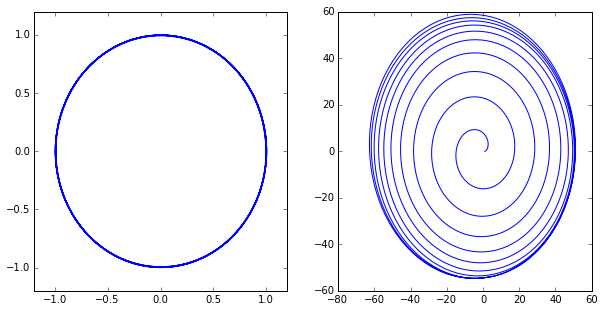

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].set_xlim(-1.2,1.2)
axs[0].set_ylim(-1.2,1.2)
axs[0].plot(pos_real[:,0],pos_real[:,1])
axs[1].plot(pos_var[:,0],pos_var[:,1]);

The left plot shows the orbit of the inner planet. Since the perturbations from the outer planet are small, it is almost on a perfect Keplerian orbit. The right plot shows the evolution of the variational particle corresponding to the inner particle. We start the variational particle at $x=1$ and can see that the particle slowly moves away from its starting point on an outward spiral. Note that the spiral is very regular, an indication of non-chaotic motion.

Let us now estimate where the inner planet would be at the end of the simulation, had it been shifted by a small amount in the $x$ direction, $\Delta x$, at the beginning of the simulation. We do this in two different ways. First, we will simply integrate the system again with the planet being shifted at the beginning:

In [8]:
DeltaX = 0.0001
sim = create_sim()
sim.particles[1].x += DeltaX
sim.integrate(2.*np.pi)
print(sim.particles[1].x, sim.particles[1].y)

(1.00120837485695, 0.015650048158793436)


Next, let us calculate the same by using the variational equations. In this case we do not shift the original particle, but integrate the variational equations and add these at the end of the simulation:

In [9]:
sim = create_sim()
var_i = sim.add_var_1st_order()
varscale= 0.000001
sim.particles[var_i+1].x = varscale  # Offset variational particle
sim.integrate(2.*np.pi)
print(sim.particles[1].x+sim.particles[var_i+1].x*DeltaX/varscale, sim.particles[1].y+sim.particles[var_i+1].y*DeltaX/varscale)

(1.001210121313625, 0.015650349898253892)


The final positions agree almost exactly. The second approach using the variational equations has one important advantage. We only need to know the initial offset at the very end of the simulation ($\Delta x$ is only used in the last line). This allows us to calculate immediately where the final position of the planet would be had we started it with an offset twice as large:

In [10]:
DeltaX *= 2.
print(sim.particles[1].x+sim.particles[var_i+1].x*DeltaX/varscale, sim.particles[1].y+sim.particles[var_i+1].y*DeltaX/varscale)

(1.0013399507922973, 0.013787090383970111)


We can do this trick not only with an offset in one direction, but with an offset in multiple directions, by adding multiple variational equations.

In [11]:
sim = create_sim()
varx_i = sim.add_var_1st_order()
vary_i = sim.add_var_1st_order()
varscale= 0.000001
sim.particles[varx_i+1].x = varscale  # Offset variational particle in x
sim.particles[vary_i+1].y = varscale  # Offset variational particle in y 
sim.integrate(2.*np.pi)
DeltaX = 0.001
DeltaY = 0.001
print(
    sim.particles[1].x+sim.particles[varx_i+1].x*DeltaX/varscale+sim.particles[vary_i+1].x*DeltaY/varscale, 
    sim.particles[1].y+sim.particles[varx_i+1].y*DeltaX/varscale+sim.particles[vary_i+1].x*DeltaY/varscale)

(1.00237418886862, -0.0011233834833542207)
